# VanDerPol Reachability Analysis Example

This example demonstrates a complete workflow for reachability verification analysis using the VanDerPol system.

| Item                             | Description                                                                                                                                                                                                                                    |
| -------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dynamical System**             | VanDerPol                                                                                                                                                                                                                                      |
| **Dimension**                    | 2D                                                                                                                                                                                                                                             |
| **Expected Verification Result** | Reachable                                                                                                                                                                                                                                      |
| **Eigenpairs**                   | Principal eigenpairs with feasible residuals                                                                                                                                                                                                   |
| **Experiment Objective**         | Extract the system's eigenfunctions through the Residual Dynamic Mode Decomposition (ResDMD) algorithm, and perform reachability bound computation based on these eigenfunctions to verify reachability from the initial set to the target set |
| **Remark**                       | This script obtains data from the limit cycle                                                                                                                                                                                                  |


In [1]:
# load the modules

import os
import sys

sys.path.append("../")

import numpy as np

import ddrv

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
/home/jianqiang/Downloads/Residual-Dynamic-Mode-Decomposition-1/examples/../ddrv/viz/vis_vector_field_2d.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


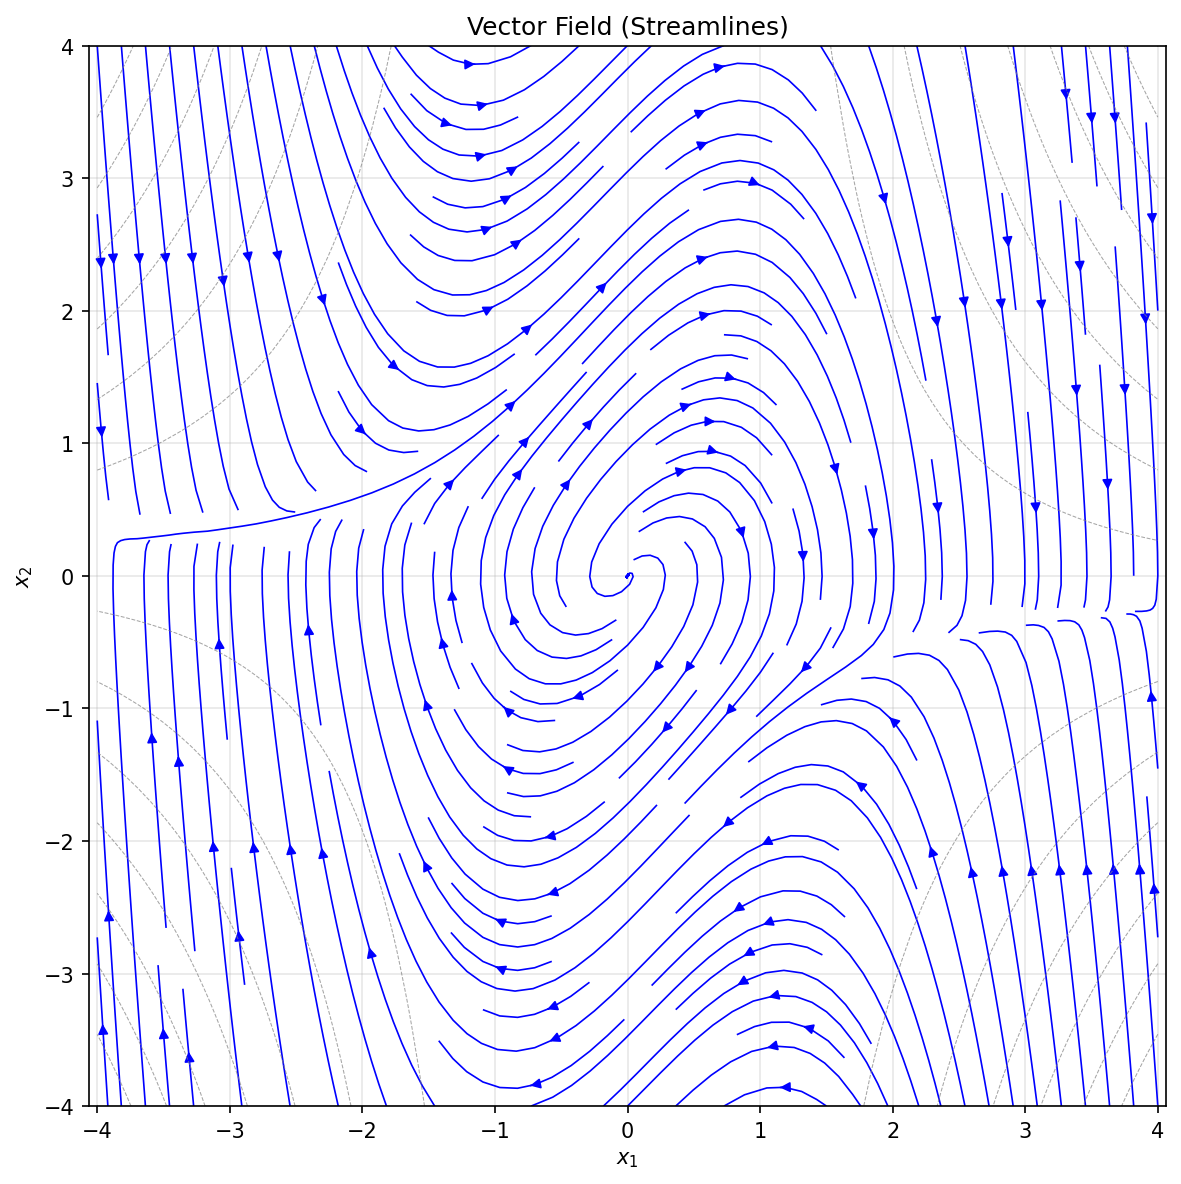

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'center': 'Vector Field (Streamlines)'}, xlabel='$x_1$', ylabel='$x_2$'>)

In [2]:
# define the dynamical system
vanderpol = ddrv.dynamic.Vanderpol()
ddrv.viz.vis_vector_field_2d(
    vanderpol.get_numerical_dynamics(),
    domain=[[-4, 4], [-4, 4]],
    step_size=0.1,
)

(2001, 3, 2)


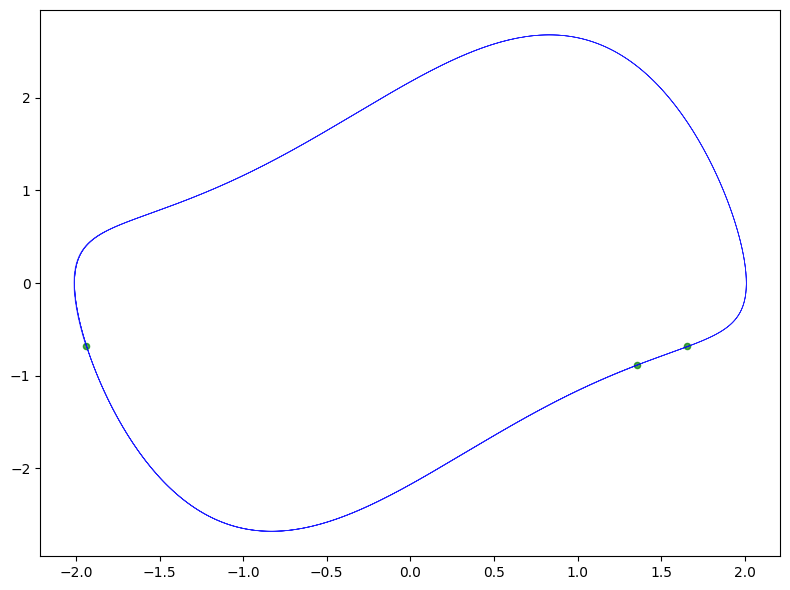

In [3]:
DT = 0.01
RANDOM_SEED = 0

# now simulate from one initial point to get the trajectory data of the limit cycle
initial_point = np.array(
    [[-1.9, 0.0], [1.5, 3], [-2, 1]]
)  # random picked three points for generating the limit cycle
traj_data_LMC, _ = ddrv.common.simulate(
    vanderpol.get_numerical_dynamics(),
    initial_point,
    0,
    20,
    DT,
)
print(traj_data_LMC.shape)
# truncate the trajectory data to the limit cycle
traj_data_LMC = traj_data_LMC[400:, :, :]

# visualize the trajectory data
ddrv.viz.vis_trajectory_2d(traj_data_LMC)

# now we have some data accurately on the limit cycle for the following steps
traj_data_LMC = traj_data_LMC.reshape(-1, 2)

(4803, 2) traj_data_LMC.shape
(200, 2) init_pts.shape
(81, 200, 2) traj_data_backward.shape
(81, 200, 2) traj_data_forward.shape


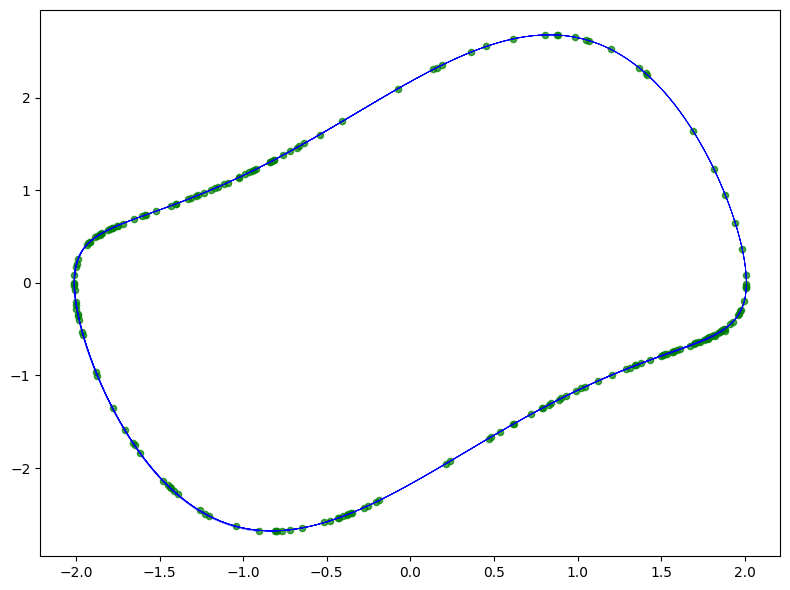

In [4]:
# now randomly select some data from the previous obtained limit cycle data
NUM_INIT_PTS = 200
print(traj_data_LMC.shape, "traj_data_LMC.shape")
# select NUM_INIT_PTS rows from the limit cycle data
init_pts = traj_data_LMC[
    np.random.choice(traj_data_LMC.shape[0], NUM_INIT_PTS, replace=False), :
]
print(init_pts.shape, "init_pts.shape")

# now compute backward trajectories from the initial points
traj_data_backward = ddrv.common.generate_trajectory_from_points(
    vanderpol,
    points=init_pts,
    num_steps=80,
    dt=DT,
    forward=False,
)
print(traj_data_backward.shape, "traj_data_backward.shape")
# flip the backward trajectory data to forward
traj_data_forward = traj_data_backward[::-1, :, :]
print(traj_data_forward.shape, "traj_data_forward.shape")

# visualize the backward trajectory data
ddrv.viz.vis_trajectory_2d(traj_data_forward)

In [5]:
# now split the trajectory data into X and Y arrays, X refers the current state, Y refers the next state
X = traj_data_forward[:-1, :, :].reshape(-1, 2)
Y = traj_data_forward[1:, :, :].reshape(-1, 2)
print(X.shape, Y.shape)

(16000, 2) (16000, 2)


In [14]:
# get the principal eigenpairs
LAM, V, residuals, observables, PX, PY, K = ddrv.algo.presdmd(
    traj_data_forward,
    k=8,
    dt=DT,
    observe_params={"basis": "poly", "degree": 12},
    thresh_ct=1e-9,
)
print(LAM)
# compute the continuous principal eigenvalues
LAM_ct = np.log(LAM) / DT
print(LAM_ct, "LAM_ct")

[1.        +0.j         0.99995554+0.00942941j 0.99995554-0.00942941j
 0.99982217+0.01885797j 0.99982217-0.01885797j 0.99959998+0.02828485j
 0.99959998-0.02828485j 0.99928899+0.03770958j]
[-4.51580995e-09+0.j          7.98146649e-08+0.94295461j
  7.98146649e-08-0.94295461j -4.01522075e-07+1.88590898j
 -4.01522075e-07-1.88590898j  7.92168328e-06+2.82886222j
  7.92168328e-06-2.82886222j  2.52091396e-05+3.771851j  ] LAM_ct
